In [36]:
import numpy as np
import pandas as pd 
from time import clock
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_digits

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import vs
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set()

In [59]:
dims = [2,3,4,5,6,7,8,9,10,11,12]
nn_reg = [0.001]
nn_arch= [(50,50)]
clusters =  [2,5,10,15,20,25,30,35,40]

In [3]:
census_data = pd.read_csv('census.csv')
census_x=census_data.drop('income',axis=1)
census_y=census_data['income']
census_y=census_y.apply(lambda z: 1 if z == '>50K' else 0)
census_x = vs.categorical_to_numerical(census_x)
census_x_log=census_x.apply(lambda z:np.log(z+.001))

In [40]:
census_x_log.shape

(45222, 13)

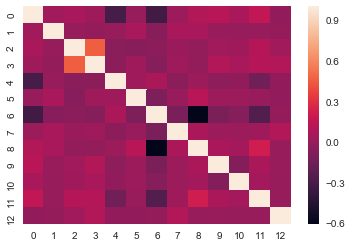

In [4]:
sns.heatmap(np.corrcoef(np.transpose(census_x_log)));

In [6]:
sse=[]
shs=[]
bic=[]
time=[]

clusters =  np.arange(2,21)

for k in clusters:
    st = clock()
    m=KMeans(k,random_state=0).fit(census_x_log)
    time.append(clock()-st)
    sse.append(m.score(census_x_log))
    shs.append(silhouette_score(census_x_log,m.predict(census_x_log),sample_size=1000))


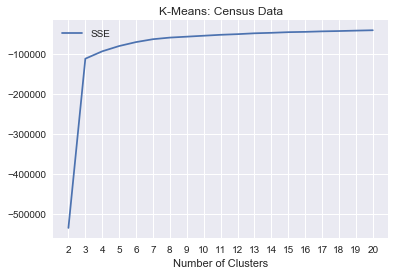

In [7]:
plt.plot(clusters,sse, label='SSE');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: Census Data');
plt.xticks(clusters);

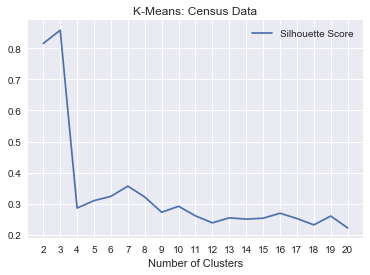

In [8]:
plt.plot(clusters,shs, label='Silhouette Score');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: Census Data');
plt.xticks(clusters);

In [10]:
kmeans = KMeans( n_clusters = 3, random_state = 0) 
clusters = kmeans.fit_predict(census_x_log) 
kmeans.cluster_centers_.shape

(3, 13)

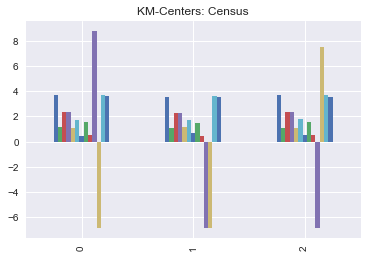

In [11]:
(pd.DataFrame(kmeans.cluster_centers_)).plot(kind='bar',title='KM-Centers: Census',legend=False);



In [13]:
from sklearn.metrics import accuracy_score 
accuracy_score(census_y, clusters)

0.20233514661005705

In [85]:
## Gausian Mixture Models

In [14]:
ll=[]
bic=[]
aic=[]
time=[]

clusters =  np.arange(2,21)

for k in clusters:
    st = clock()
    m=GaussianMixture(k,covariance_type='diag',random_state=0).fit(census_x_log)
    time.append(clock()-st)
    ll.append(m.score(census_x_log))
    aic.append(m.aic(census_x_log))
    bic.append(m.bic(census_x_log))
    

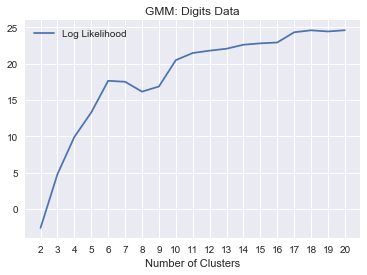

In [15]:
plt.plot(clusters,ll, label='Log Likelihood');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: Digits Data');
plt.xticks(clusters);

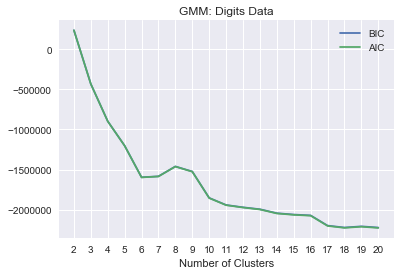

In [16]:
plt.plot(clusters,bic, label='BIC');
plt.plot(clusters,aic, label='AIC');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: Digits Data');
plt.xticks(clusters);

In [17]:
gmm=GaussianMixture(6,covariance_type='diag',random_state=0).fit(census_x_log)

In [18]:
accuracy_score(census_y,gmm.predict(census_x_log))

0.15930299411790722

In [188]:
## PCA

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(census_x_log)

In [27]:
# get eig_vals
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_vals_n = pd.Series(eig_vals)/ np.sum(eig_vals)
eig_vals_n = eig_vals_n.sort_values(ascending=False)

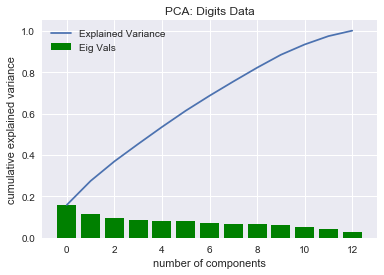

In [28]:
pca = PCA().fit(X_std) 
plt.plot( np.cumsum( pca.explained_variance_ratio_),label='Explained Variance') 
y_pos = np.arange(len(eig_vals_n))
plt.bar(y_pos,eig_vals_n,label='Eig Vals',color='g')
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance');
plt.title('PCA: Census Data');
plt.legend(loc='best');

In [31]:
def recon_error(n,data):
    mse=[]
    for i in range(n):
        pca = PCA(i,random_state=0).fit(data)
        components = pca.transform(data)
        X_projected = pca.inverse_transform(components)
        mse.append(((data - X_projected) ** 2).mean())
    return mse

In [34]:
re=recon_error(12,X_std)

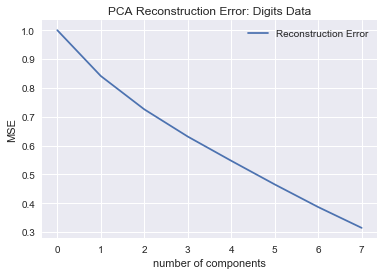

In [33]:
plt.plot(re,label='Reconstruction Error') ;
plt.xlabel('number of components') 
plt.ylabel('MSE');
plt.title('PCA Reconstruction Error: Census Data');
plt.legend(loc='best');

In [62]:
pca = PCA(.85,whiten=False,random_state=0)
pca_reduced_data = pca.fit_transform(X_std)

In [ ]:
## PCA + NN

In [42]:
grid ={'pca__n_components':dims,'NN__alpha':nn_reg,'NN__hidden_layer_sizes':nn_arch}
pca = PCA(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('pca',pca),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5)

gs.fit(X_std,census_y)
pc_nn=pd.DataFrame(gs.cv_results_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2, score=0.8069651741293532, total=   1.1s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2, score=0.811608623548922, total=   1.6s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2, score=0.8124930901050305, total=   1.1s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2, score=0.8042901371074745, total=   1.3s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.4s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=2, score=0.8078071436470198, total=   1.4s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.8s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3, score=0.8162520729684909, total=   1.3s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.2s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3, score=0.8189054726368159, total=   1.6s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.8s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3, score=0.8210060807075732, total=   1.3s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.1s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3, score=0.8140203449800973, total=   0.9s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.1s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=3, score=0.8153267720889086, total=   1.2s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4, score=0.8176893311221669, total=   0.9s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4, score=0.8226644555002764, total=   1.3s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4, score=0.8277501381978994, total=   0.9s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4, score=0.8202122954444936, total=   0.8s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=4 
[CV]  NN__alpha=0.001, NN__hidden_l

[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=12, score=0.8374792703150912, total=   0.9s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=12 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=12, score=0.8330384785493145, total=   1.2s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=12 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), pca__n_components=12, score=0.8415348888643149, total=   2.6s


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.3min finished


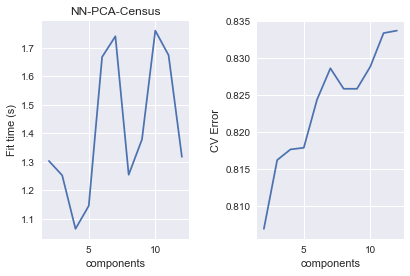

In [100]:
plt.subplot(1, 2, 1)
plt.plot(pc_nn.param_pca__n_components,pc_nn.mean_fit_time);
plt.xlabel('components')
plt.ylabel('Fit time (s)')
plt.title('NN-PCA-Census')

plt.subplot(1, 2, 2)
plt.plot(pc_nn.param_pca__n_components,pc_nn.split0_test_score);
plt.xlabel('components')
plt.ylabel('CV Error')
plt.tight_layout()

In [339]:
# PCA + K means

In [64]:
sse=[]
shs=[]
bic=[]
time=[]

clusters =  np.arange(2,21)

for k in clusters:
    st = clock()
    m=KMeans(k,random_state=0).fit(pca_reduced_data)
    time.append(clock()-st)
    sse.append(m.score(pca_reduced_data))
    shs.append(silhouette_score(pca_reduced_data,m.predict(pca_reduced_data),sample_size=1000))


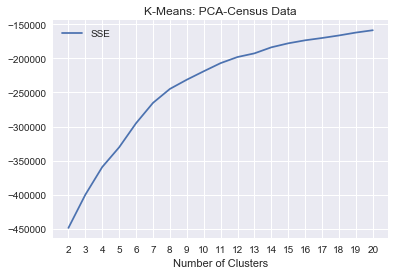

In [69]:
plt.plot(clusters,sse, label='SSE');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: PCA-Census Data');
plt.xticks(clusters);

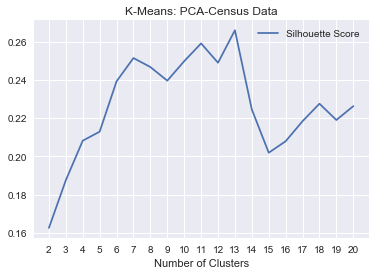

In [70]:
plt.plot(clusters,shs, label='Silhouette Score');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: PCA-Census Data');
plt.xticks(clusters);

In [71]:
pcs_km=KMeans(13,random_state=0).fit_transform(pca_reduced_data)

In [96]:
pcs_km.shape

(45222, 13)

In [103]:
grid ={'pca__n_components':[8],
       'km__n_clusters':[13],
       'NN__alpha':nn_reg,
       'NN__hidden_layer_sizes':nn_arch}
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
km = KMeans(random_state=5)
pca = PCA(random_state=5)   
pipe = Pipeline([('pca',pca),('km',km),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10)

gs.fit(X_std,census_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), km__n_clusters=13, pca__n_components=8 
[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), km__n_clusters=13, pca__n_components=8, score=0.8125248772721242, total=   2.0s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), km__n_clusters=13, pca__n_components=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), km__n_clusters=13, pca__n_components=8, score=0.8245986466763965, total=   2.6s
[CV] NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), km__n_clusters=13, pca__n_components=8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  NN__alpha=0.001, NN__hidden_layer_sizes=(50, 50), km__n_clusters=13, pca__n_components=8, score=0.8167705983813188, total=   2.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=5,
  svd_solver='auto', tol=0.0, whiten=False)), ('km', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=5, t...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [8], 'km__n_clusters': [13], 'NN__alpha': [0.001], 'NN__hidden_layer_sizes': [(50, 50)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [104]:
gs_=pd.DataFrame(gs.cv_results_)

In [105]:
gs_.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_NN__alpha,param_NN__hidden_layer_sizes,param_km__n_clusters,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.463576,0.019577,0.817965,0.819325,0.001,"(50, 50)",13,8,"{'NN__alpha': 0.001, 'NN__hidden_layer_sizes':...",1,0.812525,0.815576,0.824599,0.821215,0.816771,0.821182,0.36905,0.000318,0.005001,0.00265


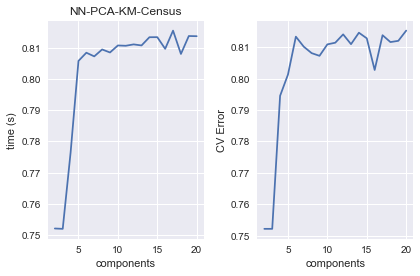

In [77]:
plt.subplot(1, 2, 1)
plt.plot(gs_.param_km__n_clusters,gs_.mean_train_score);
plt.xlabel('components')
plt.ylabel('time (s)')
plt.title('NN-PCA-KM-Census')

plt.subplot(1, 2, 2)
plt.plot(gs_.param_km__n_clusters,gs_.split0_test_score);
plt.xlabel('components')
plt.ylabel('CV Error')
plt.tight_layout()

In [ ]:
## PCA + GMM

In [78]:
ll=[]
bic=[]
aic=[]
time=[]

clusters =  np.arange(10,100,10)

for k in clusters:
    st = clock()
    m=GaussianMixture(k,covariance_type='diag',random_state=0).fit(pca_reduced_data)
    time.append(clock()-st)
    ll.append(m.score(pca_reduced_data))
    aic.append(m.aic(pca_reduced_data))
    bic.append(m.bic(pca_reduced_data))

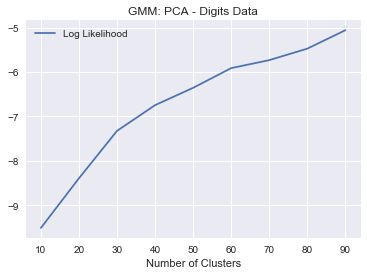

In [79]:
plt.plot(clusters,ll, label='Log Likelihood');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: PCA - Digits Data');
plt.xticks(clusters);

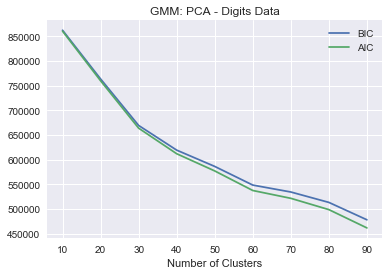

In [80]:
plt.plot(clusters,bic, label='BIC');
plt.plot(clusters,aic, label='AIC');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: PCA - Digits Data');
plt.xticks(clusters);

In [86]:
pcs_gmm=GaussianMixture(60,covariance_type='diag',random_state=0).fit(pca_reduced_data)


In [90]:
pcs_gmm_=pcs_gmm.predict_proba(pca_reduced_data)

In [97]:
pcs_gmm_.shape

(45222, 60)

In [108]:
grid ={'pca__n_components':[8],
        'gmm__n_components':[6],
       'NN__alpha':nn_reg,
       'NN__hidden_layer_sizes':nn_arch}
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
gmm = GaussianMixture()
pipe = Pipeline([('pca',pca),('gmm',gmm),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5)

gs.fit(X_std,census_y)
gs_=pd.DataFrame(gs.cv_results_)

TypeError: All intermediate steps should be transformers and implement fit and transform. 'GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)' (type <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>) doesn't

In [ ]:
gs_.head()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(pc_nn.param_pca__n_components,pc_nn.mean_fit_time);
plt.xlabel('components')
plt.ylabel('time (s)')
plt.title('NN-PCA-GMM-Census')

plt.subplot(1, 2, 2)
plt.plot(pc_nn.param_pca__n_components,pc_nn.split0_test_score);
plt.xlabel('components')
plt.ylabel('CV Error')
plt.tight_layout()

In [358]:
## ICA

In [359]:
from sklearn.decomposition import FastICA

In [367]:
dims = [2,5,10,15,20,25,30,35,40,45,50,55,60]
ica = FastICA(random_state=5,max_iter=500)
kurt = {}
for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(digitsX)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()

kurt = pd.Series(kurt) 

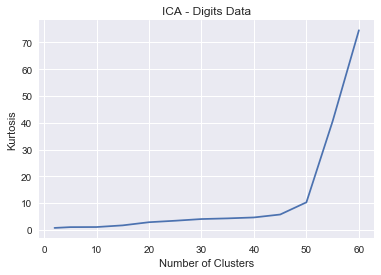

In [375]:
ax=kurt.plot(title='ICA - Digits Data');
ax.set_xlabel("Number of Clusters");
ax.set_ylabel("Kurtosis");

In [377]:
ica = FastICA(random_state=5,n_components=60).fit(digitsX)

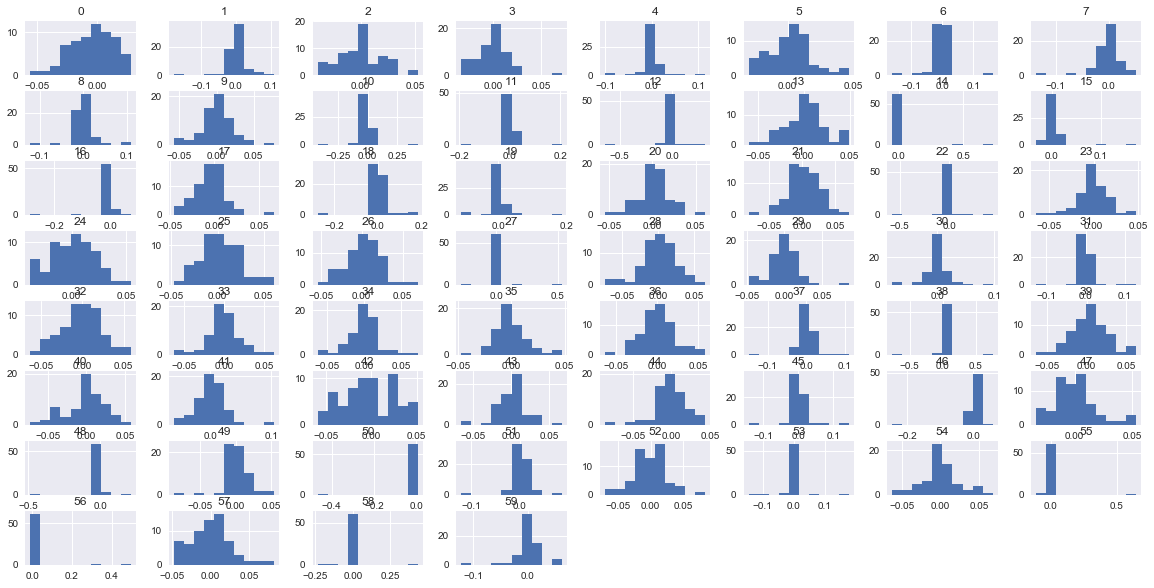

In [413]:
(pd.DataFrame(ica.components_).T).hist(figsize=(20,10));

In [ ]:
## ICA + K - Means

In [401]:
dim = 60
ica = FastICA(n_components=dim,random_state=10)
digitsX2 = ica.fit_transform(digitsX)
digits2 = pd.DataFrame(np.hstack((digitsX2,np.atleast_2d(digitsY).T)))
cols = list(range(digits2.shape[1]))
cols[-1] = 'Class'
digits2.columns = cols

In [415]:
digits2.shape

(1797, 61)

In [432]:
sse=[]
shs=[]
bic=[]
time=[]

ica_digits_x=digits2.drop('Class',axis=1)
ica_digits_y=digits2['Class']

clusters =  np.arange(10,200,20)

for k in clusters:
    st = clock()
    m=KMeans(k,random_state=0).fit(ica_digits_x)
    time.append(clock()-st)
    sse.append(m.score(ica_digits_x))
    shs.append(silhouette_score(ica_digits_x,m.predict(ica_digits_x)))

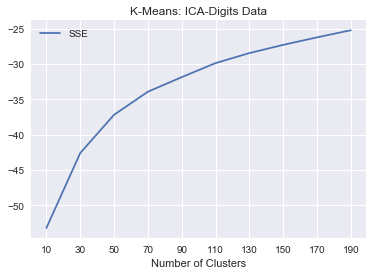

In [433]:
plt.plot(clusters,sse, label='SSE');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: ICA-Digits Data');
plt.xticks(clusters);

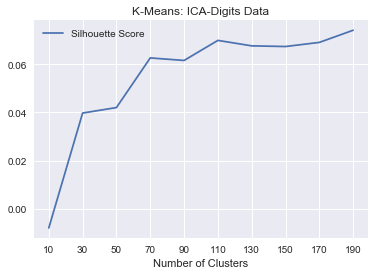

In [434]:
plt.plot(clusters,shs, label='Silhouette Score');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: ICA-Digits Data');
plt.xticks(clusters);

In [ ]:
## ICA + GMM

In [435]:
ll=[]
bic=[]
aic=[]
time=[]

clusters =  np.arange(10,100,10)

for k in clusters:
    st = clock()
    m=GaussianMixture(k,covariance_type='diag',random_state=0).fit(ica_digits_x)
    time.append(clock()-st)
    ll.append(m.score(ica_digits_x))
    aic.append(m.aic(ica_digits_x))
    bic.append(m.bic(ica_digits_x))

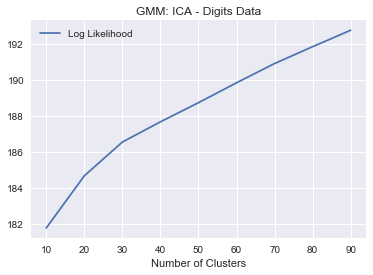

In [436]:
plt.plot(clusters,ll, label='Log Likelihood');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: ICA - Digits Data');
plt.xticks(clusters);

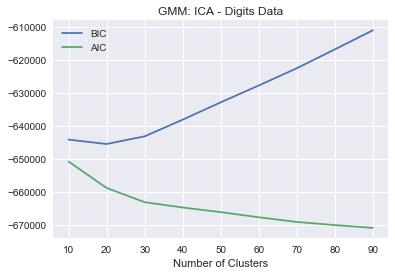

In [437]:
plt.plot(clusters,bic, label='BIC');
plt.plot(clusters,aic, label='AIC');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: ICA - Digits Data');
plt.xticks(clusters);

In [ ]:
## RP

In [441]:
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from itertools import product

In [451]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv

In [447]:
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(digitsX), digitsX)
srp =pd.DataFrame(tmp).T

In [ ]:
ax=kurt.plot(title='ICA - Digits Data');
ax.set_xlabel("Number of Clusters");
ax.set_ylabel("Kurtosis");

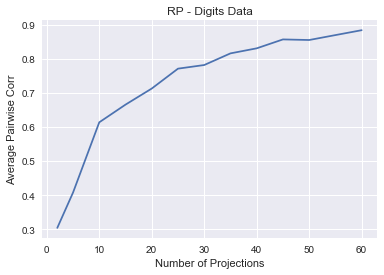

In [460]:
ax = srp.mean(axis=1).plot(title='RP - Digits Data')
ax.set_xlabel("Number of Projections");
ax.set_ylabel("Average Pairwise Corr");

In [452]:
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(digitsX)  
    tmp[dim][i] = reconstructionError(rp, digitsX)
srp_recon =pd.DataFrame(tmp).T

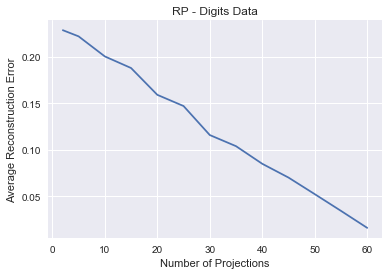

In [461]:
ax = srp_recon.mean(axis=1).plot(title='RP - Digits Data')
ax.set_xlabel("Number of Projections");
ax.set_ylabel("Average Reconstruction Error");

In [ ]:
## RP + Kmeans

In [462]:
dim = 60
rp = SparseRandomProjection(n_components=dim,random_state=5)
digitsX2 = rp.fit_transform(digitsX)

In [471]:
sse=[]
shs=[]
bic=[]
time=[]

clusters =  np.arange(2,60,5)

for k in clusters:
    st = clock()
    m=KMeans(k,random_state=0).fit(digitsX2)
    time.append(clock()-st)
    sse.append(m.score(digitsX2))
    shs.append(silhouette_score(digitsX2,m.predict(digitsX2)))

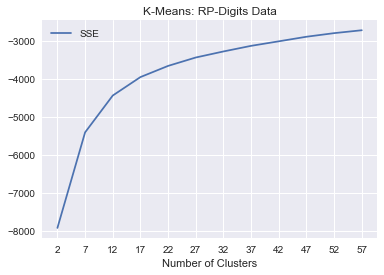

In [474]:
plt.plot(clusters,sse, label='SSE');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: RP-Digits Data');
plt.xticks(clusters);

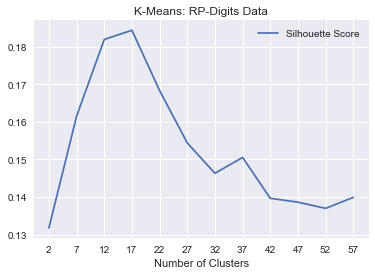

In [475]:
plt.plot(clusters,shs, label='Silhouette Score');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('K-Means: RP-Digits Data');
plt.xticks(clusters);

In [ ]:
## RP + GMM

In [476]:
ll=[]
bic=[]
aic=[]
time=[]

clusters =  np.arange(2,100,5)

for k in clusters:
    st = clock()
    m=GaussianMixture(k,covariance_type='diag',random_state=0).fit(digitsX2)
    time.append(clock()-st)
    ll.append(m.score(digitsX2))
    aic.append(m.aic(digitsX2))
    bic.append(m.bic(digitsX2))

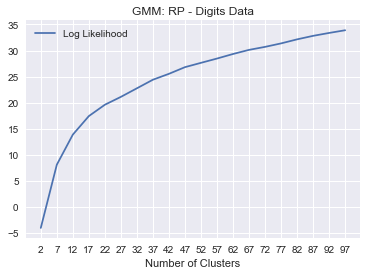

In [477]:
plt.plot(clusters,ll, label='Log Likelihood');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: RP - Digits Data');
plt.xticks(clusters);

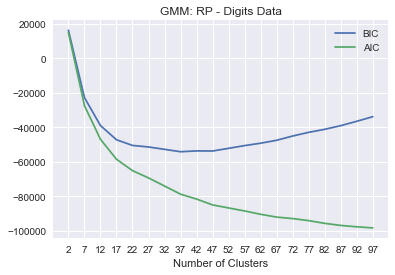

In [478]:
plt.plot(clusters,bic, label='BIC');
plt.plot(clusters,aic, label='AIC');
plt.legend(loc='best');
plt.xlabel('Number of Clusters')
plt.title('GMM: RP - Digits Data');
plt.xticks(clusters);

In [197]:
dims = [2,5,10,15,20,25,30,35,40,45,50,55,60]
nn_reg = [10**-x for x in range(1,5)]
nn_arch= [(50,50),(50,),(25,),(25,25),(100,25,100)]

In [199]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [200]:
grid ={'pca__n_components':dims,'NN__alpha':nn_reg,'NN__hidden_layer_sizes':nn_arch}
pca = PCA(random_state=5)       
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('pca',pca),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
gs.fit(digitsX,digits.target)

In [205]:
gs.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_NN__alpha', 'param_NN__hidden_layer_sizes', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [206]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=25, random_state=5,
  svd_solver='auto', tol=0.0, whiten=False)), ('NN', MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

In [ ]:
## ica

In [ ]:
ica = FastICA(random_state=5)
kurt = {}
for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(digitsX)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()